In [23]:
from sklearn.datasets import load_svmlight_file
from sklearn.model_selection import train_test_split
import numpy as np
import matplotlib.pyplot as plt
import random

In [24]:
def get_data(dataset):
    data = load_svmlight_file("./{}".format(dataset))
    input_data = data[0].toarray()
    return input_data, data[1]

In [25]:
def sigmoid(w, X):
    return 1.0/(1.0+np.e**(-np.dot(X, w)))

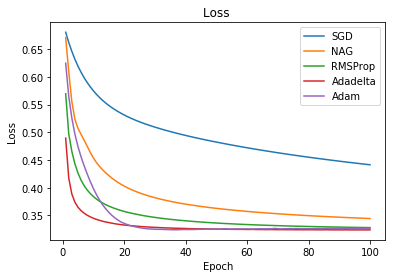

In [33]:
batch_size=10000
nEpochs=100
eta=0.01
algorithm=0

# get dataset
# x_train, x_validation, y_train, y_validation = get_dataset(input_data, label)
x_train, y_train = get_data('a9a')
x_validation, y_validation = get_data('a9a.t')

# handle data
temp = np.zeros((len(x_validation), 1))
x_validation = np.column_stack((x_validation, temp))
y_train[y_train==-1] = 0
y_validation[y_validation==-1] = 0

# modify bias
train_column = np.ones((len(x_train), 1))
x_train = np.column_stack((x_train, train_column))
validation_column = np.ones((len(x_validation), 1))
x_validation = np.column_stack((x_validation, validation_column))

# number of batch
num_batch = int(len(x_train)/batch_size + 1)

for algorithm in range(5):    
    # initialize the v(t-1) NAG
    v_t_1 = np.zeros((123+1, 1))
    # initialize the g(t-1) RMSProp
    g_t_1 = np.zeros((123+1, 1))
    # initialize the delta(t-1) AdaDelta
    delta_t_1 = np.zeros((123+1, 1))
    # initialize the v(t-1) and m(t-1) Adam
    v_t_1_a = np.zeros((123+1, 1))
    m_t_1 = np.zeros((123+1, 1))
    
    training_loss_array = []
    validationing_loss_array = []
    
    # init w
    w = w = np.zeros((124, 1))
    
    for i in range(nEpochs):
        training_loss = 0.0
        validationing_loss = 0.0
        # shuffle each batch in different epochs
        shuffle = random.sample(range(len(x_train)), len(x_train))
        for j in range(num_batch):
            # batch
            if j!=num_batch-1:
                # the data in each batch
                x = x_train[shuffle[j*batch_size:(j+1)*batch_size]]
                y = y_train[shuffle[j*batch_size:(j+1)*batch_size]]
            elif j==num_batch-1:
                # the data in each batch
                x = x_train[shuffle[j*batch_size:]]
                y = y_train[shuffle[j*batch_size:]]

            if algorithm==0:
                # SGD
                # calculate the gradient
                grad = (np.dot(np.transpose(x), (sigmoid(w, x) - y.reshape(-1, 1))))/len(x)
                # update
                w = w - eta * grad
            elif algorithm==1:
                # NAG
                grad = (np.dot(np.transpose(x), (sigmoid((w-0.9*v_t_1), x) - y.reshape(-1, 1))))/len(x)
                v_t = 0.9*v_t_1 + eta * grad
                # update
                w = w - v_t
                v_t_1 = v_t.copy()

            elif algorithm==2:
                # RMSProp
                # calculate the gradient
                grad = (np.dot(np.transpose(x), (sigmoid(w, x) - y.reshape(-1, 1))))/len(x)
                g_t = grad.copy()
                g_t = 0.1 * np.square(g_t_1) + 0.9 * np.square(g_t)

                # update
                w = w - (eta*grad)/np.sqrt(np.mean(g_t)+0.001)
                g_t_1 = g_t.copy()

            elif algorithm==3:
                # AdaDelta
                # calculate the gradient
                grad = (np.dot(np.transpose(x), (sigmoid(w, x) - y.reshape(-1, 1))))/len(x)
                g_t = grad.copy()
                g_t = 0.1 * np.square(g_t_1) + 0.9 * np.square(g_t)

                # update
                delta_w = (np.sqrt(np.mean(delta_t_1)+0.001)/np.sqrt(np.mean(g_t)+0.001))*grad
                w = w - delta_w
                delta_t = 0.9 * delta_t_1 + 0.1 * np.square(delta_w)
                delta_t_1 = delta_t.copy()            

            elif algorithm==4:
                # Adam
                # calculate the gradient
                grad = (np.dot(np.transpose(x), (sigmoid(w, x) - y.reshape(-1, 1))))/len(x)
                m_t = 0.9 * m_t_1 + 0.1 * grad
                v_t_a = 0.999 * v_t_1_a + 0.001 * np.square(grad)
                m_t_hat = m_t / ( 1 - np.power(0.9, i*num_batch+j+1))
                v_t_a_hat = v_t_a / ( 1 - np.power(0.999, i*num_batch+j+1))
                # update
                w = w - eta * m_t_hat / (np.sqrt(v_t_a_hat) + 1e-8)
                m_t = m_t_hat
                v_t_a = v_t_a_hat        

            # training error and validationing error
            training_loss += -np.mean(y_train.reshape(-1, 1) * np.log(sigmoid(w, x_train)) + (1 - y_train.reshape(-1, 1)) * (np.log(1 - sigmoid(w, x_train))))
            validationing_loss += -np.mean(y_validation.reshape(-1, 1) * np.log(sigmoid(w, x_validation)) + (1 - y_validation.reshape(-1, 1)) * (np.log(1 - sigmoid(w, x_validation))))

        training_loss = training_loss/num_batch
        validationing_loss = validationing_loss/num_batch
        training_loss_array.append(training_loss)
        validationing_loss_array.append(validationing_loss)
    if algorithm==0:
        algorithm_loss_array = validationing_loss_array
    else:
        algorithm_loss_array = np.vstack((algorithm_loss_array,validationing_loss_array))
    

#plot
x = np.array(range(1, nEpochs+1))

algorithm_name_str = ['SGD', 'NAG', 'RMSProp', 'Adadelta', 'Adam']

for i in range(5):
    plt.plot(x, np.array(algorithm_loss_array[i]), label=algorithm_name_str[i])
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Loss ")

plt.legend();
plt.show()